In [1]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
from astropy.io import fits
import astropy.units as u

import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%load_ext autoreload
%autoreload 2

In [2]:
rootdir = Path("/Volumes/LaCie 8TB/wfsdat")
# use find to make this csv list
with open(rootdir / "reanalyze_csvs_2019.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames, sort=True)

g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,12578,1,binospec,12578
f5,1425,1,f5,1425
mmirs,3036,1,mmirs,3036
newf9,471,1,newf9,471


In [3]:
data.tail()

,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,focus,...,seeing,tiltx,tilty,time,transx,transy,wavefront_rms,wfs,xcen,ycen
480,1.1373,59.895839,-0.0,-0.000,13.640,61.559131,30.0,wfs_ff_cal_img_2019.0703.110928.fits,-0.00,14424.95,...,1.413552,287.73,174.73,2019-07-03T11:09:28.375000,-568.76,2562.70,206.984391,binospec,269.201516,241.971760
481,1.1362,59.858503,0.0,0.000,13.640,61.659252,30.0,wfs_ff_cal_img_2019.0703.111001.fits,2.46,14429.24,...,1.546609,287.68,175.27,2019-07-03T11:10:01.713000,-568.55,2559.53,242.954401,binospec,278.736439,248.128736
482,1.1351,59.819343,-0.0,0.000,13.781,61.762689,30.0,wfs_ff_cal_img_2019.0703.111034.fits,0.00,14433.04,...,1.425522,287.20,175.11,2019-07-03T11:10:34.921000,-567.61,2557.18,191.087901,binospec,272.146744,244.931771
483,1.1340,59.780150,0.0,0.293,13.895,61.865064,30.0,wfs_ff_cal_img_2019.0703.111108.fits,-4.69,14434.63,...,1.493729,286.97,175.04,2019-07-03T11:11:08.151000,-566.22,2554.41,317.396467,binospec,273.752414,243.969172
484,1.1329,59.741226,-0.0,1.840,14.199,61.965024,30.0,wfs_ff_cal_img_2019.0703.111141.fits,-0.00,14435.55,...,1.594234,286.73,174.95,2019-07-03T11:11:41.359000,-568.34,2552.28,317.507866,binospec,276.258712,244.209847


In [4]:
data['comaerr'] = np.hypot(data['cc_x_err'], data['cc_y_err'])

In [5]:
fixed = data[(np.abs(data['focerr']) < 20.) & (data['comaerr'] < 5.) & (data['el'] != np.nan) & (data['focus'] != 0.0) & (data['el'] < 89.9) & (data['file'] != "f9wfs_20180830-151213.fits")]
fixed = fixed.dropna()

# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

In [6]:
f9 = fixed[(fixed['wfs'] == 'newf9') | (fixed['wfs'] == 'oldf9')]
f5 = fixed[fixed['wfs'] == 'f5']
mmirs = fixed[fixed['wfs'] == 'mmirs']
bino = fixed[fixed['wfs'] == 'binospec']

In [7]:
mmirs[mmirs['focus'] > 13000.]

,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,focus,...,tiltx,tilty,time,transx,transy,wavefront_rms,wfs,xcen,ycen,comaerr
ut,,,,,,,,,,,,,,,,,,,,,


<IPython.core.display.Javascript object>


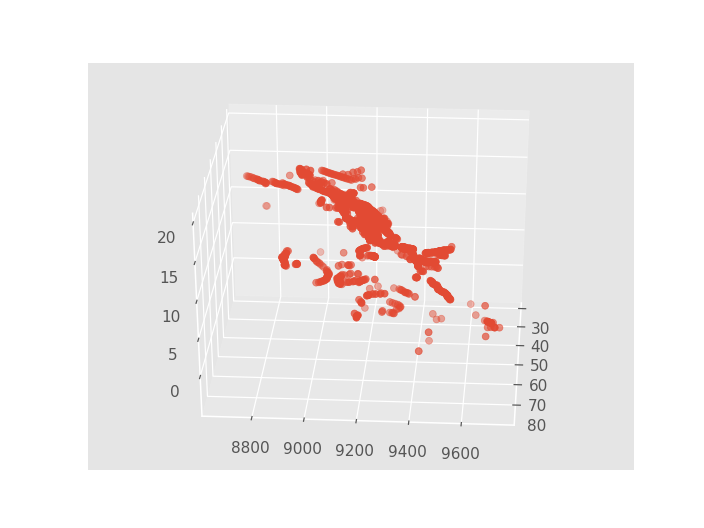

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mmirs['el'], mmirs['focus'], mmirs['osst'])
plt.show()

<IPython.core.display.Javascript object>


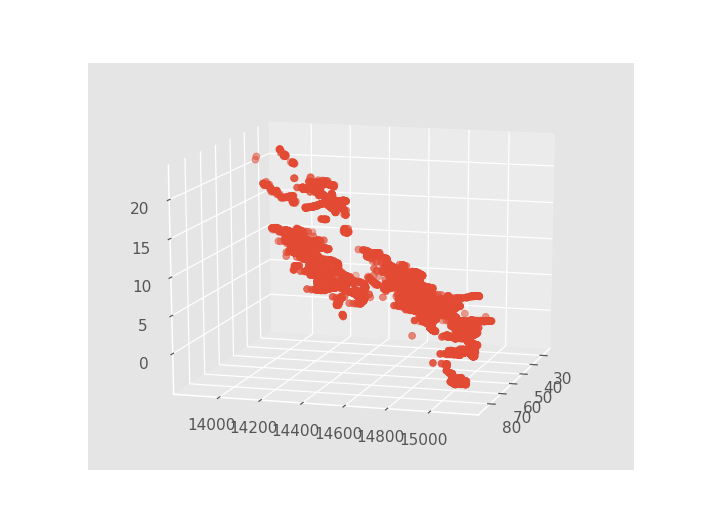

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bino['el'], bino['focus'], bino['osst'])
plt.show()

<IPython.core.display.Javascript object>


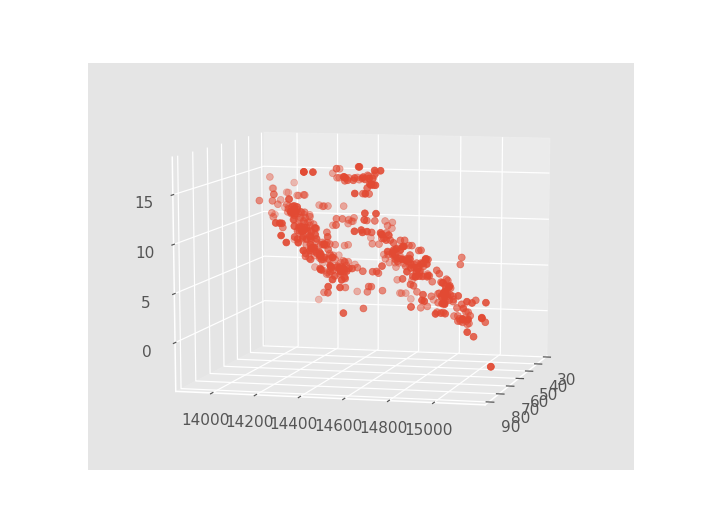

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(f5['el'], f5['focus'], f5['osst'])
plt.show()

<IPython.core.display.Javascript object>


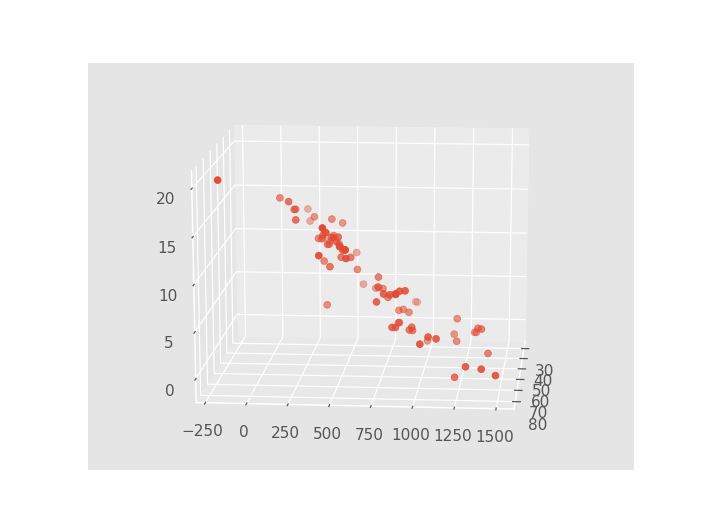

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(f9['el'], f9['focus'], f9['osst'])
plt.show()

In [12]:
fixed.to_csv("../raw_data/2019_wfs.csv")